In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.models import load_model


# from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
import tensorflow.keras.layers as L
# import tensorflow.keras.layers as Layers

C:\Users\admin\AppData\Local\Temp\ipykernel_2344\4235188594.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


________________________________________________________________________________
# Data Preperation & Cleaning



## 1. Load .csv into a dataframe with the image paths

In [2]:
# Load the metadata into a DataFrame
metadata_path = 'C:\\Users\\admin\\Desktop\\archive\\Data_Entry_2017.csv'
all_xray_df = pd.read_csv(metadata_path)

# Adjust the glob pattern to match the new subfolder structure and file naming pattern
image_folder_path = 'C:\\Users\\admin\\Desktop\\archive'
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(image_folder_path, 'images_0**', 'images', '*.png'))}

# Check if all files follow the expected naming pattern
expected_files = all_xray_df['Image Index'].tolist()
missing_files = [file for file in expected_files if file not in all_image_paths]
print(f"Number of files not found: {len(missing_files)}")

# Map Full Image Paths to the DataFrame
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Print the number of missing image paths after mapping
nan_or_none_count = all_xray_df['path'].isna().sum()
print(f"Total count of rows without valid image paths: {nan_or_none_count}")

# Display the head of the DataFrame to verify the 'path' column
all_xray_df


Number of files not found: 0
Total count of rows without valid image paths: 0


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...


In [3]:
# an extra column, 'unnamed:11' appeared. Check out what values are inside
print(all_xray_df['Unnamed: 11'].unique())


[nan]


In [4]:
# 'unamed:11' column only contains '[nan]', therefore it does not contain any useful data and can be dropped. 
# Likely to be an issue with the original .csv file
all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)


In [5]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,C:\Users\admin\Desktop\archive\images_001\imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,C:\Users\admin\Desktop\archive\images_001\imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,C:\Users\admin\Desktop\archive\images_001\imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,C:\Users\admin\Desktop\archive\images_001\imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,C:\Users\admin\Desktop\archive\images_001\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_012\imag...


## 2. Check the Datatypes


In [6]:
all_xray_df.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
path                            object
dtype: object

## 3. Remove Outliers from Selected Columns

### 3.1: Follow-up #

In [7]:
print(all_xray_df['Follow-up #'].describe())
follow_up_counts = all_xray_df['Follow-up #'].value_counts().sort_index()

follow_up_counts

count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64


Follow-up #
0      30805
1      13302
2       9189
3       7089
4       5759
       ...  
179        1
180        1
181        1
182        1
183        1
Name: count, Length: 184, dtype: int64

In [8]:
# who got 183 x rays??
# Code to find which 'Follow-up #' values have only 1 count
single_follow_ups = all_xray_df['Follow-up #'].value_counts()
single_follow_ups = single_follow_ups[single_follow_ups == 1]

print(single_follow_ups)

Follow-up #
178    1
182    1
181    1
180    1
179    1
175    1
177    1
176    1
174    1
173    1
183    1
Name: count, dtype: int64


In [9]:
# Follow-up # column seems clean

### 3.2: Patient Age

In [10]:
print(all_xray_df['Patient Age'].describe())


count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64


In [11]:
## find out number of people who have >100 in this column

age_over_100_count = all_xray_df[all_xray_df['Patient Age'] > 100].shape[0]
print(f"Number of people with age > 100: {age_over_100_count}")

Number of people with age > 100: 16


In [12]:
# Find the number of people with age greater than 100
over_100 = all_xray_df[all_xray_df['Patient Age'] > 100]

# Print the number of people
print(f"Number of people with age > 100: {over_100.shape[0]}")

# Print the rows where 'Patient Age' is greater than 100
over_100


Number of people with age > 100: 16


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_003\imag...
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_006\imag...
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,C:\Users\admin\Desktop\archive\images_006\imag...
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,C:\Users\admin\Desktop\archive\images_007\imag...
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,C:\Users\admin\Desktop\archive\images_007\imag...
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,C:\Users\admin\Desktop\archive\images_007\imag...
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,C:\Users\admin\Desktop\archive\images_008\imag...
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,C:\Users\admin\Desktop\archive\images_009\imag...
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_009\imag...
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_010\imag...


In [13]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]
print(f"DataFrame shape after removal: {all_xray_df.shape}")
# oldest person in the world is 117, anything above that should be removed

DataFrame shape after removal: (112104, 12)


In [14]:
print(all_xray_df['Patient Age'].describe())


count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64


In [15]:
print(all_xray_df['Patient Gender'].describe())


count     112104
unique         2
top            M
freq       63328
Name: Patient Gender, dtype: object


In [16]:
#figure out the lower section, why are there <16 kids here

# Find the number of people with age less than 16
under_10 = all_xray_df[all_xray_df['Patient Age'] < 10]

# Print the number of people
print(f"Number of people with age <16: {under_10.shape[0]}")

# Print the rows where 'Patient Age' is greater than 100
under_10



Number of people with age <16: 1403


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
4340,00001179_000.png,No Finding,0,1179,9,F,AP,2048,2500,0.171,0.171,C:\Users\admin\Desktop\archive\images_001\imag...
5821,00001564_000.png,No Finding,0,1564,9,M,AP,2048,2500,0.171,0.171,C:\Users\admin\Desktop\archive\images_002\imag...
5843,00001574_000.png,No Finding,0,1574,8,M,PA,2048,2500,0.171,0.171,C:\Users\admin\Desktop\archive\images_002\imag...
6182,00001676_000.png,No Finding,0,1676,8,F,PA,2048,2500,0.171,0.171,C:\Users\admin\Desktop\archive\images_002\imag...
6234,00001686_000.png,No Finding,0,1686,8,M,AP,2048,2500,0.168,0.168,C:\Users\admin\Desktop\archive\images_002\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...
111745,00030609_022.png,Infiltration,22,30609,6,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_012\imag...
111746,00030609_023.png,No Finding,23,30609,6,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_012\imag...
111747,00030609_024.png,No Finding,24,30609,6,M,AP,3056,2544,0.139,0.139,C:\Users\admin\Desktop\archive\images_012\imag...
111748,00030609_025.png,Infiltration,25,30609,6,M,AP,2544,3056,0.139,0.139,C:\Users\admin\Desktop\archive\images_012\imag...


In [17]:
under_10.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000
mean,7.114754,16043.683535,6.509622,2343.110478,2360.614398,0.153095,0.153095
std,13.337775,7668.865087,2.245398,392.859169,400.127592,0.017184,0.017184
min,0.000000,1179.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,10739.500000,5.000000,2048.000000,2048.000000,0.139000,0.139000
50%,1.000000,15996.000000,7.000000,2350.000000,2500.000000,0.143000,0.143000
75%,7.000000,21939.500000,9.000000,2544.000000,2544.000000,0.168000,0.168000
max,80.000000,30609.000000,9.000000,3056.000000,3056.000000,0.194311,0.194311


### 3.3: Patient Gender

In [18]:
gender_counts = all_xray_df['Patient Gender'].value_counts()
m_count = gender_counts.get('M', 0)
f_count = gender_counts.get('F', 0)
other_count = gender_counts.sum() - (m_count + f_count)

print(f"Number of 'M': {m_count}")
print(f"Number of 'F': {f_count}")
print(f"Number of other categories: {other_count}")

Number of 'M': 63328
Number of 'F': 48776
Number of other categories: 0


### 3.4: View Position

In [19]:
View_counts = all_xray_df['View Position'].value_counts()
PA_count = View_counts.get('PA', 0)
AP_count = View_counts.get('AP', 0)
other_count = View_counts.sum() - (PA_count + AP_count)

print(f"Number of 'PA': {PA_count}")
print(f"Number of 'AP': {AP_count}")
print(f"Number of other categories: {other_count}")

Number of 'PA': 67299
Number of 'AP': 44805
Number of other categories: 0


### 3.5 Image Metadata

In [20]:
print(all_xray_df['OriginalImage[Width'].describe())


count    112104.000000
mean       2646.035253
std         341.243771
min        1143.000000
25%        2500.000000
50%        2518.000000
75%        2992.000000
max        3827.000000
Name: OriginalImage[Width, dtype: float64


In [21]:
print(all_xray_df['Height]'].describe())


count    112104.000000
mean       2486.393153
std         401.270806
min         966.000000
25%        2048.000000
50%        2544.000000
75%        2991.000000
max        4715.000000
Name: Height], dtype: float64


In [22]:
print(all_xray_df['OriginalImagePixelSpacing[x'].describe())


count    112104.000000
mean          0.155651
std           0.016174
min           0.115000
25%           0.143000
50%           0.143000
75%           0.168000
max           0.198800
Name: OriginalImagePixelSpacing[x, dtype: float64


In [23]:
print(all_xray_df['y]'].describe())


count    112104.000000
mean          0.155651
std           0.016174
min           0.115000
25%           0.143000
50%           0.143000
75%           0.168000
max           0.198800
Name: y], dtype: float64


## 4. Split the 'labelled' columns into binary columns

In [24]:
# Assuming all_xray_df is your DataFrame and it's loaded and has the 'Finding Labels' column

# List of disease labels, including 'No Finding'
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 
                  'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 
                  'Pneumonia', 'Pneumothorax', 'No Finding']

# Make sure that all_xray_df is not a view or a copy of another DataFrame
all_xray_df = all_xray_df.copy()

# Creating binary columns for each disease label using .loc
for label in disease_labels:
    all_xray_df.loc[:, label] = all_xray_df['Finding Labels'].apply(lambda findings: 
                                                                    1 if label in findings.split('|') else 0)

# Display the head of the DataFrame to check the new columns
all_xray_df


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,1,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1


## 4. Split into Train, Validate & Test

In [25]:
#OG way of splitting the set, causes leakage
#from sklearn.model_selection import train_test_split
# First, split into train + validation set and test set (80-20 split)
#train_valid_df, test_df = train_test_split(all_xray_df, test_size=0.2, random_state=2024)

# Now split the train + validation set into train set and validation set (80-20 split)
#train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=2024) # 0.25 x 0.8 = 0.2

# Now you have three sets: train_df, valid_df, and test_df
#print(f"Train set size: {train_df.shape}")
#print(f"Validation set size: {valid_df.shape}")
#print(f"Test set size: {test_df.shape}")

In [26]:
from sklearn.model_selection import train_test_split

# Assuming 'Patient ID' is the column with patient identifiers in all_xray_df

# First, get a list of unique patient IDs and split this list into train + validation and test IDs
unique_patients = all_xray_df['Patient ID'].unique()
train_valid_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=2024)

# Now split the train + validation IDs into train IDs and validation IDs
train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.25, random_state=2024)  # 0.25 * 0.8 = 0.2

# Create the actual dataframes based on the split IDs
train_df = all_xray_df[all_xray_df['Patient ID'].isin(train_ids)]
valid_df = all_xray_df[all_xray_df['Patient ID'].isin(valid_ids)]
test_df = all_xray_df[all_xray_df['Patient ID'].isin(test_ids)]

## 5. Prevent Data Leakage
our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [27]:
def check_for_leakage(df1, df2, patient_col):
    """
    Check for data leakage between two datasets by comparing unique patient identifiers.
    
    Args:
    df1 (DataFrame): the first dataset
    df2 (DataFrame): the second dataset
    patient_col (str): the name of the column containing patient identifiers
    
    Returns:
    bool: True if there is data leakage, False otherwise
    """
    df1_patients_unique = set(df1[patient_col].unique())
    df2_patients_unique = set(df2[patient_col].unique())
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    # If there's any overlap in patient identifiers, there's leakage
    leakage = len(patients_in_both_groups) > 0
    return leakage

# Example usage:
# Assuming 'Patient ID' is the column with patient identifiers in all_xray_df and the datasets have been created
# Check for leakage between train and test sets
leakage_between_train_test = check_for_leakage(train_df, test_df, 'Patient ID')
print(f"Leakage between train and test sets: {leakage_between_train_test}")

# Check for leakage between train and validation sets
leakage_between_train_valid = check_for_leakage(train_df, valid_df, 'Patient ID')
print(f"Leakage between train and validation sets: {leakage_between_train_valid}")

# Check for leakage between validation and test sets
leakage_between_valid_test = check_for_leakage(valid_df, test_df, 'Patient ID')
print(f"Leakage between validation and test sets: {leakage_between_valid_test}")


Leakage between train and test sets: False
Leakage between train and validation sets: False
Leakage between validation and test sets: False


## 6. Preparing Images with tf.data

- to resize images to the same size
- memory efficiency: loads iamges in batches
- preprocess images the same way the images were preprocessed when training the models (e.g., normalizing pixel values). Consistent preprocessing is essential for the model to perform correctly.

In [28]:
import tensorflow as tf

def load_image_and_process(filepath, label, augment=False):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    #if augment:
       # image = tf.image.random_flip_left_right(image)
       # image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Assuming you already have train_df, valid_df, and test_df ready, with label columns properly set up
# Convert the label data to categorical format if it's not already done
train_labels = train_df[disease_labels].values
valid_labels = valid_df[disease_labels].values
test_labels = test_df[disease_labels].values

# Create a tf.data.Dataset from the DataFrame
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['path'].values, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['path'].values, test_labels))

# Process the image and batch the datasets
batch_size = 32
train_ds = train_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# trying this time without augmentation

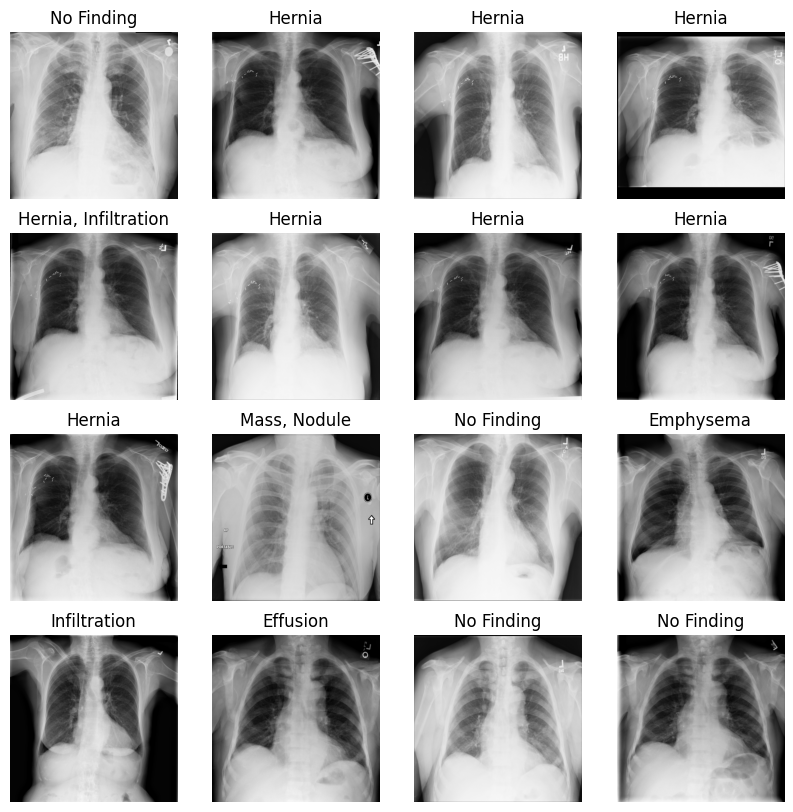

In [29]:
# Visualize the images
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis("off")
    plt.show()

# Fetch a batch of images and labels from the dataset
image_batch, label_batch = next(iter(train_ds))

# Since labels are in binary format, you might want to map them back to the disease names for display
def format_labels(label_batch, disease_labels):
    formatted_labels = []
    for labels in label_batch:
        label_names = [disease_labels[idx] for idx, label in enumerate(labels) if label == 1]
        if not label_names:  # If no disease is present
            label_names = ['No Finding']
        formatted_labels.append(', '.join(label_names))
    return formatted_labels

# Convert binary labels back to string labels for easier interpretation
formatted_labels = format_labels(label_batch.numpy(), disease_labels)

# Call the function to display the images and their corresponding labels
show_batch(image_batch.numpy(), formatted_labels)


______________________________________________________________________________
# Exploratory data analysis/visualization

## 1. Explore Correlation between patient's age & whether they have a disease
No correlation, only 0.07

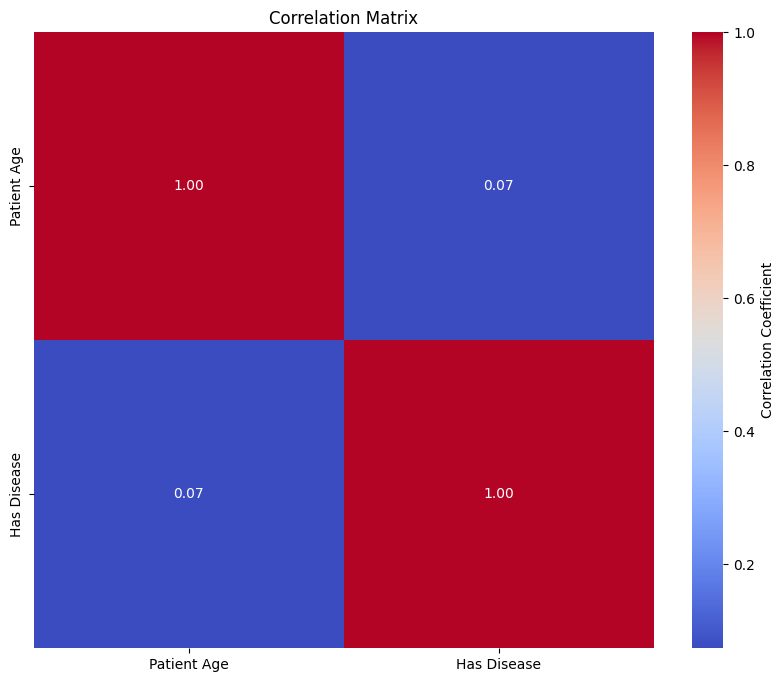

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the DataFrame to avoid altering the original data
df = all_xray_df.copy()

# Create a binary column where 1 indicates the presence of any disease except 'No Finding'
df['Has Disease'] = df['Finding Labels'].apply(lambda x: 0 if 'No Finding' in x else 1)

# Select only the columns we need for the correlation matrix
columns_to_consider = ['Patient Age', 'Has Disease']
correlation_df = df[columns_to_consider]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.show()


## 2. Correlation between age and sex for each disease

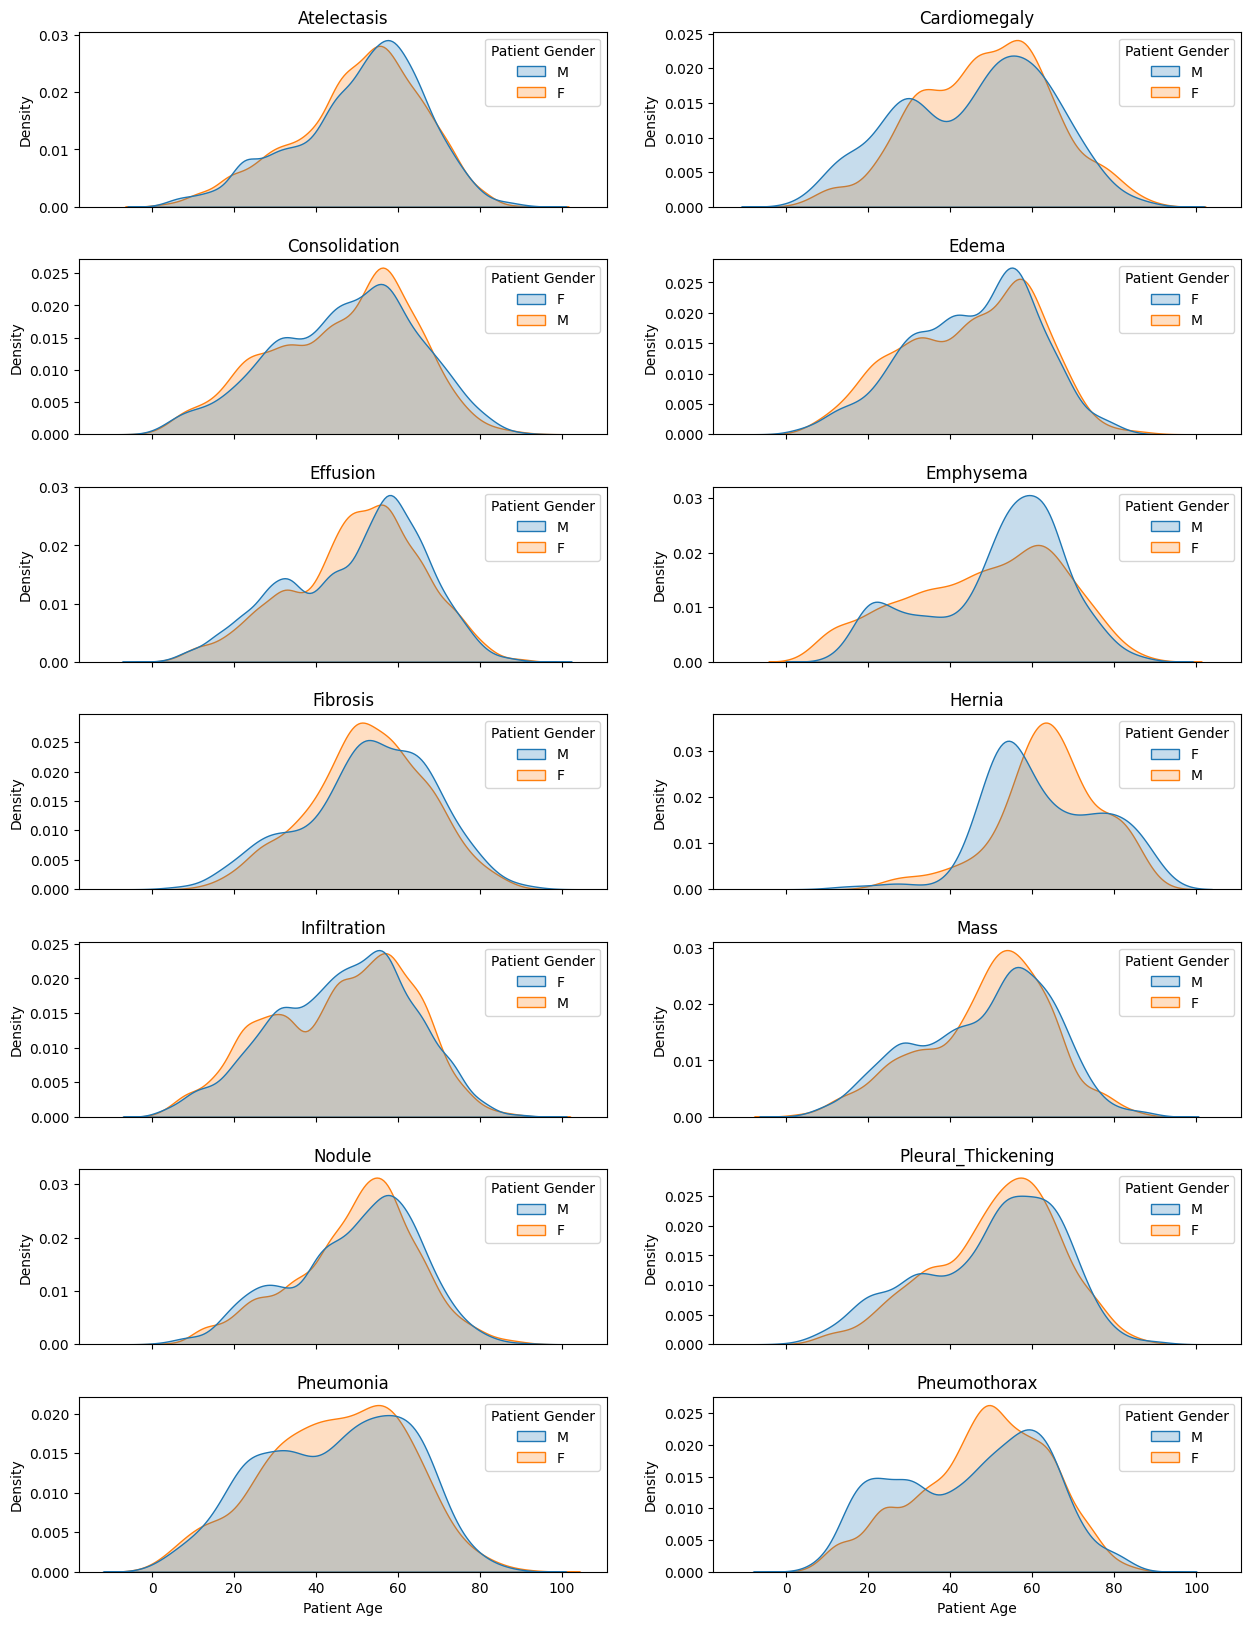

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of pathologies
pathology_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                  'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                  'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']  # Update this list as necessary

# Verify the correct column name for patient age in your DataFrame
age_column = 'Patient Age'  # Change this if your column name is different

# Initialize the subplot structure
f, axarr = plt.subplots(len(pathology_list) // 2 + len(pathology_list) % 2, 2, sharex=True, figsize=(15, 20))
i, j = 0, 0

for pathology in pathology_list:
    # Filter the DataFrame for the current pathology excluding 'No Finding'
    pathology_df = all_xray_df[all_xray_df[pathology] == 1]
    
    # Plot the KDE for the current pathology
    sns.kdeplot(data=pathology_df, x=age_column, hue='Patient Gender', ax=axarr[i, j], common_norm=False, fill=True)
    axarr[i, j].set_title(pathology)

    # Update the indices for the next subplot
    j = (j + 1) % 2
    if j == 0:
        i += 1

# Remove any empty subplots
for k in range(i, len(axarr)):
    f.delaxes(axarr[k, j])
    j = (j + 1) % 2

# Adjust layout and display the plot
f.subplots_adjust(hspace=0.3)
plt.show()


In [32]:
import pandas as pd

# Assuming 'all_xray_df' is your DataFrame with a 'Patient Age' column and binary columns for each disease
# List of diseases based on the columns in your DataFrame (excluding 'No Finding')
disease_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']  # Update with your actual diseases

# Initialize a dictionary to hold the correlation values
disease_age_correlations = {}

# Calculate the correlation between each disease presence and patient age
for disease in disease_list:
    correlation = all_xray_df['Patient Age'].corr(all_xray_df[disease])
    disease_age_correlations[disease] = correlation

# Print the correlation values
for disease, corr_value in disease_age_correlations.items():
    print(f"Correlation between 'Patient Age' and presence of {disease}: {corr_value:.2f}")



Correlation between 'Patient Age' and presence of Atelectasis: 0.07
Correlation between 'Patient Age' and presence of Cardiomegaly: 0.00
Correlation between 'Patient Age' and presence of Consolidation: -0.00
Correlation between 'Patient Age' and presence of Edema: -0.01
Correlation between 'Patient Age' and presence of Effusion: 0.06
Correlation between 'Patient Age' and presence of Emphysema: 0.03
Correlation between 'Patient Age' and presence of Fibrosis: 0.04
Correlation between 'Patient Age' and presence of Hernia: 0.04
Correlation between 'Patient Age' and presence of Infiltration: -0.02
Correlation between 'Patient Age' and presence of Mass: 0.03
Correlation between 'Patient Age' and presence of Nodule: 0.04
Correlation between 'Patient Age' and presence of Pleural_Thickening: 0.04
Correlation between 'Patient Age' and presence of Pneumonia: -0.02
Correlation between 'Patient Age' and presence of Pneumothorax: -0.01


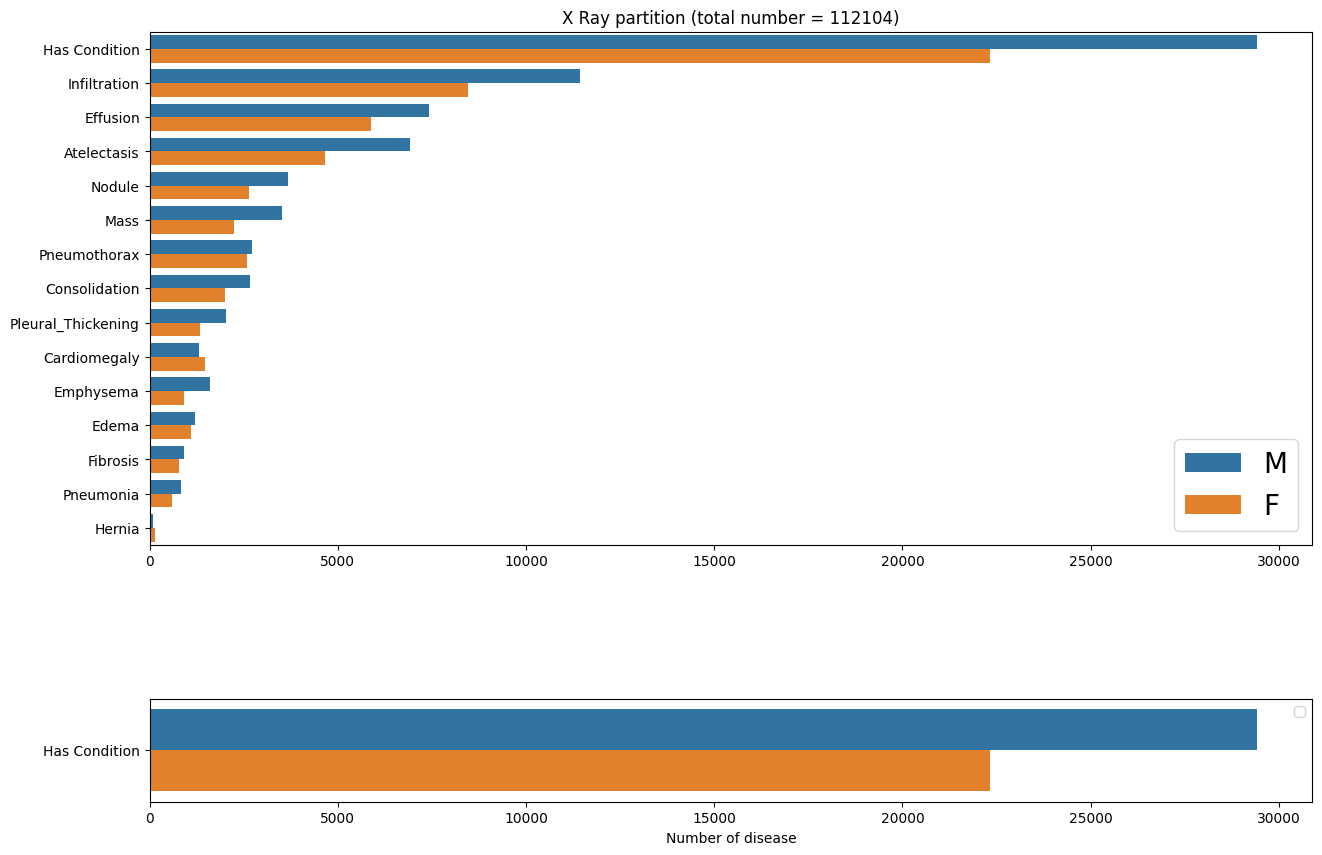

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# Assuming your actual DataFrame 'all_xray_df' has a 'Patient Gender' column and binary columns for each disease
# Here's how you would set up your data for the plots:

diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Calculate the number of conditions per patient excluding 'No Finding'
all_xray_df['Conditions Count'] = all_xray_df[diseases].sum(axis=1)
# Create a binary column for patients with at least one condition
all_xray_df['Has Condition'] = all_xray_df['Conditions Count'] > 0

# Create a 'melted' DataFrame for plotting
melted_df = pd.melt(all_xray_df, id_vars=['Patient Gender'], value_vars=diseases + ['Has Condition'], var_name='Category', value_name='Count')
melted_df = melted_df[melted_df['Count'] > 0]

# Initialize the matplotlib figure and GridSpec
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])

# The first subplot - for all diseases
ax1 = plt.subplot(gs[0])
sns.countplot(y='Category', hue='Patient Gender', data=melted_df, ax=ax1, order=melted_df['Category'].value_counts().index)
ax1.set(xlabel='', ylabel='', title='X Ray partition (total number = {})'.format(len(all_xray_df)))
ax1.legend(fontsize=20)

# The second subplot - for 'Has Condition' which indicates at least one condition present
ax2 = plt.subplot(gs[1])
condition_df = melted_df[melted_df['Category'] == 'Has Condition']
sns.countplot(y='Category', hue='Patient Gender', data=condition_df, ax=ax2)
ax2.set(xlabel='Number of disease', ylabel='')
ax2.legend('')

# Adjust layout spacing
plt.subplots_adjust(hspace=0.5)
plt.show()


________________________________________________________________________________________________________________________
# Machine Learning Techniques

## 1. Construct a CNN using keras
More complex and deeper network + learning rate scheduler

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 50:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    # Make sure all lines within the function are indented at the same level
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming the input images are 512x512 pixels with 3 color channels (RGB)
input_shape = (512, 512, 3)
# Assuming we have 15 classes
num_classes = 15

# Build the model
model = build_model(input_shape, num_classes)

# Print the model summary to see the structure and parameters
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 512, 512, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512, 512, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,022,031 (64.93 MB)

 Trainable params: 17,021,071 (64.93 MB)

 Non-trainable params: 960 (3.75 KB)

## 2. Train the model

Epoch 1/3
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 14540s 7s/step - accuracy: 0.4228 - loss: 0.3585 - val_accuracy: 0.5324 - val_loss: 0.2251
Epoch 2/3
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 13677s 7s/step - accuracy: 0.5539 - loss: 0.2116 - val_accuracy: 0.4696 - val_loss: 0.2972
Epoch 3/3
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 13495s 6s/step - accuracy: 0.5543 - loss: 0.2094 - val_accuracy: 0.5357 - val_loss: 0.2079


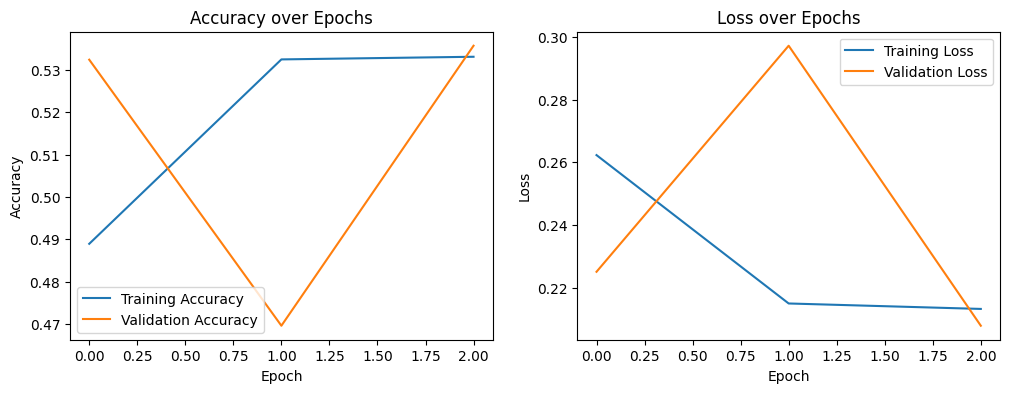

In [35]:
import tensorflow as tf

# Assuming your model is defined and named as 'model'
# For example:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(len(disease_list), activation='sigmoid')  # 'disease_list' from your diseases
# ])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for multi-label classification
    metrics=['accuracy']
)

# Assuming 'train_dataset' and 'valid_dataset' are the tf.data.Dataset objects for training and validation
#Define the number of epochs to train for
epochs = 3

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds
)

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


In [38]:
import numpy as np

# This function assumes that 'test_Y' is a NumPy array or a TensorFlow tensor
# where each row corresponds to a sample and each column to a class.
# The values in 'test_Y' should be binary (0 or 1), indicating the absence or presence
# of the class in the sample, respectively.

def print_class_distribution(labels, predictions):
    # Calculate the percentage of positive examples for each class
    class_percentages = 100 * np.mean(predictions, axis=0)
    
    # Print out the percentage of positive examples for each class
    for label, percentage in zip(labels, class_percentages):
        print('{label}: {percentage:.2f}%'.format(label=label, percentage=percentage))

# Assuming you have a list of class labels corresponding to your model's output
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
              'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
              'Pleural_Thickening', 'Pneumonia', 'Pneumothorax','No Finding']

# And assuming you have a test set of true labels (not predictions) in a NumPy array
# Let's simulate this with random binary data for demonstration purposes:
test_Y = np.random.randint(2, size=(1000, len(all_labels)))  # Simulated binary labels for 100 samples

# Now you can call the function with your labels and predictions
print_class_distribution(all_labels, test_Y)


Atelectasis: 49.40%
Cardiomegaly: 52.80%
Consolidation: 51.40%
Edema: 50.00%
Effusion: 50.90%
Emphysema: 49.80%
Fibrosis: 49.10%
Infiltration: 47.70%
Mass: 50.70%
Nodule: 52.80%
Pleural_Thickening: 50.70%
Pneumonia: 51.00%
Pneumothorax: 45.80%
No Finding: 51.30%
